<center><a href="https://5loi.com/about_loi"> <img src="images/DLI_Header.png" alt="Header" style="width: 400px;"/> </a></center>

# 6. 评估
| Assessment

恭喜你完成了今天的课程！希望这是一段充满乐趣的旅程，并留下了一些新的技能作为纪念。现在是时候检验这些技能了。

在本评估中，挑战是训练一个能够根据 [MNIST 数据集](https://en.wikipedia.org/wiki/MNIST_database) 生成手写图像的新模型。传统上，神经网络会有一个测试数据集，但对于生成式 AI 来说并非如此。美在 beholder 的眼里，作为开发者，过度拟合是否可以接受取决于你。

因此，我们创建了一个在 MNIST 数据集上训练的分类器模型。它在 MNIST 测试数据集上的准确率超过 99%。如果这个模型能够正确识别你生成的图像的 95%，你将获得证书！


## 6.1 数据集
| The Dataset

让我们开始吧，以下是本评估中使用的库。


In [1]:
import glob
import torch
import torch.nn.functional as F
import torch.nn as nn

from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms

# Visualization tools
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.utils import save_image, make_grid

# User defined libraries
from utils import other_utils
from utils import ddpm_utils
from utils import UNet_utils

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

我们之前使用的 FashionMnist 数据集在结构上与 MNIST 类似，因此我们将使用大部分相同的代码来加载它。我们不会随机水平翻转，因为数字通常不应该反向阅读。


In [2]:
def load_MNIST(data_transform, train=True):
    return torchvision.datasets.MNIST(
        "./data/",
        download=True,
        train=train,
        transform=data_transform,
    )

def load_transformed_MNIST(img_size, batch_size):
    data_transforms = [
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),  # Scales data into [0,1]
    ]

    data_transform = transforms.Compose(data_transforms)
    train_set = load_MNIST(data_transform, train=True)
    test_set = load_MNIST(data_transform, train=False)
    data = torch.utils.data.ConcatDataset([train_set, test_set])
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=True)
    return data, dataloader

我们将挑战的分类器模型期望图像大小为 `28x28` 像素。图像也是黑白的。有 `10` 个类别，每个数字对应一个类别。


In [3]:
IMG_SIZE = 28
IMG_CH = 1
BATCH_SIZE = 128
N_CLASSES = 10
data, dataloader = load_transformed_MNIST(IMG_SIZE, BATCH_SIZE)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 125292201.56it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 40044857.46it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 285580022.16it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 8600690.19it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## 6.2 设置扩散
| Setting Up Diffusion

让我们从设置扩散过程开始。为了节省时间，我们已经在下面列出了 `Beta` 进度表推荐的超参数。


In [12]:
nrows = 10
ncols = 15

T = nrows * ncols
B_start = 0.0001
B_end = 0.02
B = torch.linspace(B_start, B_end, T).to(device)

**TODO**: 我们还需要计算我们在  `q` 和 `reverse_q` 函数中将使用的一些变量。你能替换下面的 `FIXME` 吗？


In [13]:
# a = 1.0 - B
# a_bar = FIXME(a, dim=0)
# sqrt_a_bar = FIXME(a_bar)  # Mean Coefficient
# sqrt_one_minus_a_bar = FIXME(1 - a_bar)  # St. Dev. Coefficient

# # Reverse diffusion variables
# sqrt_a_inv = FIXME(1 / a)
# pred_noise_coeff = (1 - a) / FIXME(1 - a_bar)  # Predicted Noise Coefficient

In [14]:
a = 1.0 - B
a_bar = torch.cumprod(a, dim=0) #  Cumulative product along dimension 0
sqrt_a_bar = torch.sqrt(a_bar)  #  Square root of the cumulative product 
sqrt_one_minus_a_bar = torch.sqrt(1 - a_bar)  #  Square root of 1 minus cumulative product 

# Reverse diffusion variables
sqrt_a_inv = torch.sqrt(1 / a) # Square root of the inverse of alpha
pred_noise_coeff = (1 - a) / torch.sqrt(1 - a_bar)  # Predicted Noise Coefficient

**TODO**: 下面的 `q` 函数几乎完成了，但我们需要找到图像与噪声的正确比例。这是如何做到的？


In [15]:
# def q(x_0, t):
#         t = t.int()
#         noise = torch.randn_like(x_0)
#         sqrt_a_bar_t = sqrt_a_bar[t, None, None, None]
#         sqrt_one_minus_a_bar_t = sqrt_one_minus_a_bar[t, None, None, None]

#         x_t = FIXME * x_0 + FIXME * noise
#         return x_t, noise

In [16]:
def q(x_0, t):
        t = t.int()
        noise = torch.randn_like(x_0)
        sqrt_a_bar_t = sqrt_a_bar[t, None, None, None]
        sqrt_one_minus_a_bar_t = sqrt_one_minus_a_bar[t, None, None, None]

        x_t = sqrt_a_bar_t * x_0 + sqrt_one_minus_a_bar_t * noise
        return x_t, noise

请花点时间验证结果是否符合预期。图像是否从清晰可辨开始，然后消失在噪声中？


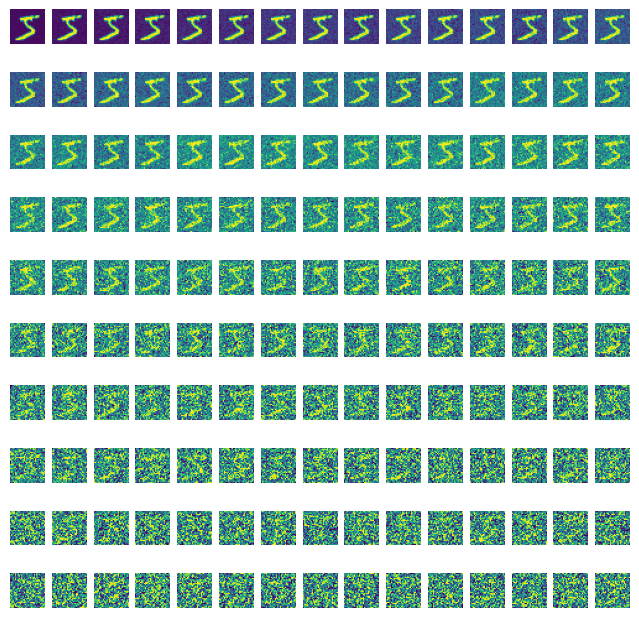

In [17]:
plt.figure(figsize=(8, 8))
x_0 = data[0][0].to(device)
xs = []

for t in range(T):
    t_tenser = torch.Tensor([t]).type(torch.int64)
    x_t, _ = q(x_0, t_tenser)
    img = torch.squeeze(x_t).cpu()
    xs.append(img)
    ax = plt.subplot(nrows, ncols, t + 1)
    ax.axis('off')
    other_utils.show_tensor_image(x_t)

**TODO**:  `reverse_q` 函数大部分已经完成，但有一些 `FIXME`。每个 `FIXME` 可以是以下之一：
* `x_t` - 潜伏图像(latent image)
* `t` - 当前时间步(timestep)
* `e_t` - 在当前时间步预测的噪声(predicted noise)


In [19]:
# @torch.no_grad()
# def reverse_q(x_t, t, e_t):
#     t = t.int()
#     pred_noise_coeff_t = pred_noise_coeff[t]
#     sqrt_a_inv_t = sqrt_a_inv[t]
#     u_t = sqrt_a_inv_t * (FIXME - pred_noise_coeff_t * FIXME)
#     if FIXME[0] == 0:  # All t values should be the same
#         return u_t  # Reverse diffusion complete!
#     else:
#         B_t = B[t - 1]  # Apply noise from the previos timestep
#         new_noise = torch.randn_like(x_t)
#         return u_t + torch.sqrt(B_t) * new_noise

In [53]:
@torch.no_grad()
def reverse_q(x_t, t, e_t):
    t = t.int()
    pred_noise_coeff_t = pred_noise_coeff[t]
    sqrt_a_inv_t = sqrt_a_inv[t]
    u_t = sqrt_a_inv_t * (x_t - pred_noise_coeff_t * e_t)
    if t[0] == 0:  # All t values should be the same
        return u_t  # Reverse diffusion complete!
    else:
        B_t = B[t - 1]  # Apply noise from the previos timestep
        new_noise = torch.randn_like(x_t)
        return u_t + torch.sqrt(B_t) * new_noise

## 6.3 设置 U-Net
| Setting up a U-Net

我们将使用与之前相同的 U-Net 架构：


In [21]:
class UNet(nn.Module):
    def __init__(
        self, T, img_ch, img_size, down_chs=(64, 64, 128), t_embed_dim=8, c_embed_dim=10
    ):
        super().__init__()
        self.T = T
        up_chs = down_chs[::-1]  # Reverse of the down channels
        latent_image_size = img_size // 4  # 2 ** (len(down_chs) - 1)
        small_group_size = 8
        big_group_size = 32

        # Inital convolution
        self.down0 = ResidualConvBlock(img_ch, down_chs[0], small_group_size)

        # Downsample
        self.down1 = DownBlock(down_chs[0], down_chs[1], big_group_size)
        self.down2 = DownBlock(down_chs[1], down_chs[2], big_group_size)
        self.to_vec = nn.Sequential(nn.Flatten(), nn.GELU())

        # Embeddings
        self.dense_emb = nn.Sequential(
            nn.Linear(down_chs[2] * latent_image_size**2, down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[2] * latent_image_size**2),
            nn.ReLU(),
        )
        self.sinusoidaltime = SinusoidalPositionEmbedBlock(t_embed_dim)
        self.t_emb1 = EmbedBlock(t_embed_dim, up_chs[0])
        self.t_emb2 = EmbedBlock(t_embed_dim, up_chs[1])
        self.c_embed1 = EmbedBlock(c_embed_dim, up_chs[0])
        self.c_embed2 = EmbedBlock(c_embed_dim, up_chs[1])

        # Upsample
        self.up0 = nn.Sequential(
            nn.Unflatten(1, (up_chs[0], latent_image_size, latent_image_size)),
            GELUConvBlock(up_chs[0], up_chs[0], big_group_size),
        )
        self.up1 = UpBlock(up_chs[0], up_chs[1], big_group_size)
        self.up2 = UpBlock(up_chs[1], up_chs[2], big_group_size)

        # Match output channels and one last concatenation
        self.out = nn.Sequential(
            nn.Conv2d(2 * up_chs[-1], up_chs[-1], 3, 1, 1),
            nn.GroupNorm(small_group_size, up_chs[-1]),
            nn.ReLU(),
            nn.Conv2d(up_chs[-1], img_ch, 3, 1, 1),
        )

    def forward(self, x, t, c, c_mask):
        down0 = self.down0(x)
        down1 = self.down1(down0)
        down2 = self.down2(down1)
        latent_vec = self.to_vec(down2)

        latent_vec = self.dense_emb(latent_vec)
        t = t.float() / self.T  # Convert from [0, T] to [0, 1]
        t = self.sinusoidaltime(t)
        t_emb1 = self.t_emb1(t)
        t_emb2 = self.t_emb2(t)

        c = c * c_mask
        c_emb1 = self.c_embed1(c)
        c_emb2 = self.c_embed2(c)

        up0 = self.up0(latent_vec)
        up1 = self.up1(c_emb1 * up0 + t_emb1, down2)
        up2 = self.up2(c_emb2 * up1 + t_emb2, down1)
        return self.out(torch.cat((up2, down0), 1))

**TODO**: 不幸的是，模块块的名称已经被打乱了。你能根据函数的作用添加正确的模块名称吗？每个模块都有一个：
* `GELUConvBlock`
* `RearrangePoolBlock`
* `DownBlock`
* `UpBlock`
* `SinusoidalPositionEmbedBlock`
* `EmbedBlock`
* `ResidualConvBlock`


In [22]:
class DownBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super(DownBlock, self).__init__()
        layers = [
            GELUConvBlock(in_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
            RearrangePoolBlock(out_chs, group_size),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [23]:
class EmbedBlock(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedBlock, self).__init__()
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
            nn.Unflatten(1, (emb_dim, 1, 1)),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)

In [24]:
class GELUConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, group_size):
        super().__init__()
        layers = [
            nn.Conv2d(in_ch, out_ch, 3, 1, 1),
            nn.GroupNorm(group_size, out_ch),
            nn.GELU(),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [25]:
class RearrangePoolBlock(nn.Module):
    def __init__(self, in_chs, group_size):
        super().__init__()
        self.rearrange = Rearrange("b c (h p1) (w p2) -> b (c p1 p2) h w", p1=2, p2=2)
        self.conv = GELUConvBlock(4 * in_chs, in_chs, group_size)

    def forward(self, x):
        x = self.rearrange(x)
        return self.conv(x)

In [26]:
class ResidualConvBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super().__init__()
        self.conv1 = GELUConvBlock(in_chs, out_chs, group_size)
        self.conv2 = GELUConvBlock(out_chs, out_chs, group_size)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        out = x1 + x2
        return out

In [27]:
class SinusoidalPositionEmbedBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

In [28]:
class UpBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super(UpBlock, self).__init__()
        layers = [
            nn.ConvTranspose2d(2 * in_chs, out_chs, 2, 2),
            GELUConvBlock(out_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        x = torch.cat((x, skip), 1)
        x = self.model(x)
        return x

现在所有部分都已定义，让我们定义模型。


In [29]:
model = UNet_utils.UNet(
    T, IMG_CH, IMG_SIZE, down_chs=(64, 64, 128), t_embed_dim=8, c_embed_dim=N_CLASSES
)
print("Num params: ", sum(p.numel() for p in model.parameters()))
model = torch.compile(model.to(device))

Num params:  2547457


## 6.4 模型训练
| Model Training

**TODO**: 我们应该创建一个函数来随机丢弃上下文。这个函数是做什么的？


In [31]:
# def get_context_mask(c, drop_prob):
#     c_hot = F.one_hot(c.to(torch.int64), num_classes=N_CLASSES).to(device)
#     c_mask = torch.FIXME(torch.ones_like(c_hot).float() - drop_prob).to(device)
#     return c_hot, c_mask

In [32]:
def get_context_mask(c, drop_prob):
    c_hot = F.one_hot(c.to(torch.int64), num_classes=N_CLASSES).to(device)
    c_mask = torch.bernoulli(torch.ones_like(c_hot).float() - drop_prob).to(device)
    return c_hot, c_mask

**TODO**: 接下来，让我们定义损失函数。我们应该使用什么类型的损失函数？


In [33]:
# def get_loss(model, x_0, t, *model_args):
#     x_noisy, noise = q(x_0, t)
#     noise_pred = model(x_noisy, t/T, *model_args)
#     return F.FIXME(noise, noise_pred)

In [34]:
def get_loss(model, x_0, t, *model_args):
    x_noisy, noise = q(x_0, t)
    noise_pred = model(x_noisy, t/T, *model_args)
    return F.mse_loss(noise, noise_pred)

这主要是为了我们的利益，以验证模型是否训练正确。


In [35]:
def sample_images(model, img_ch, img_size, ncols, *model_args, axis_on=False):
    # Noise to generate images from
    x_t = torch.randn((1, img_ch, img_size, img_size), device=device)
    plt.figure(figsize=(8, 8))
    hidden_rows = T / ncols
    plot_number = 1

    # Go from T to 0 removing and adding noise until t = 0
    for i in range(0, T)[::-1]:
        t = torch.full((1,), i, device=device).float()
        e_t = model(x_t, t, *model_args)  # Predicted noise
        x_t = reverse_q(x_t, t, e_t)
        if i % hidden_rows == 0:
            ax = plt.subplot(1, ncols+1, plot_number)
            if not axis_on:
                ax.axis('off')
            other_utils.show_tensor_image(x_t.detach().cpu())
            plot_number += 1
    plt.show()

**TODO**:  是时候训练模型了！你能修复 `FIXME` 并开始训练吗？


In [36]:
# optimizer = Adam(model.parameters(), lr=0.001)
# epochs = 5
# preview_c = 0

# model.train()
# for epoch in range(epochs):
#     for step, batch in enumerate(dataloader):
#         c_drop_prob = FIXME
#         optimizer.zero_grad()

#         t = torch.randint(0, T, (BATCH_SIZE,), device=device).float()
#         x = batch[0].to(device)
#         c_hot, c_mask = get_context_mask(FIXME, c_drop_prob)  # New
#         loss = get_loss(model, x, t, c_hot, c_mask)
#         loss.backward()
#         optimizer.step()

#         if epoch % 1 == 0 and step % 100 == 0:
#             print(f"Epoch {epoch} | Step {step:03d} | Loss: {loss.item()} | C: {preview_c}")
#             c_drop_prob = 0 # Do not drop context for preview
#             c_hot, c_mask = get_context_mask(torch.Tensor([preview_c]), c_drop_prob)
#             sample_images(model, IMG_CH, IMG_SIZE, ncols, c_hot, c_mask)
#             preview_c = (preview_c + 1) % N_CLASSES

Epoch 0 | Step 000 | Loss: 1.1248549222946167 | C: 0


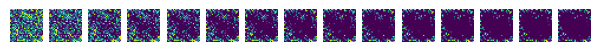

Epoch 0 | Step 100 | Loss: 0.10715465247631073 | C: 1


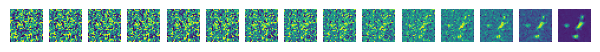

Epoch 0 | Step 200 | Loss: 0.07153540849685669 | C: 2


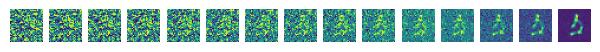

Epoch 0 | Step 300 | Loss: 0.052779603749513626 | C: 3


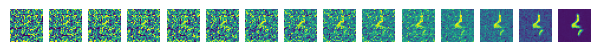

Epoch 0 | Step 400 | Loss: 0.06140969693660736 | C: 4


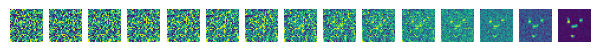

Epoch 0 | Step 500 | Loss: 0.049440640956163406 | C: 5


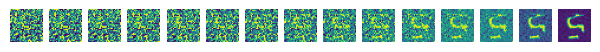

Epoch 1 | Step 000 | Loss: 0.043795790523290634 | C: 6


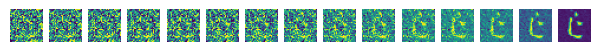

Epoch 1 | Step 100 | Loss: 0.03871564567089081 | C: 7


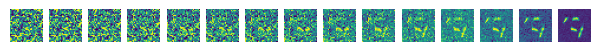

Epoch 1 | Step 200 | Loss: 0.04315190762281418 | C: 8


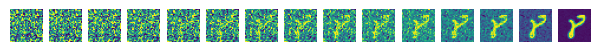

Epoch 1 | Step 300 | Loss: 0.050555285066366196 | C: 9


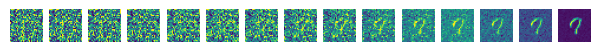

Epoch 1 | Step 400 | Loss: 0.03930125758051872 | C: 0


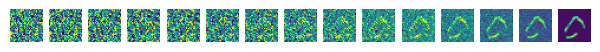

Epoch 1 | Step 500 | Loss: 0.04113498330116272 | C: 1


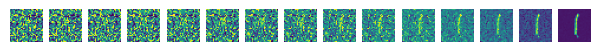

Epoch 2 | Step 000 | Loss: 0.043329380452632904 | C: 2


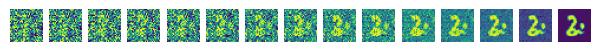

Epoch 2 | Step 100 | Loss: 0.03963353484869003 | C: 3


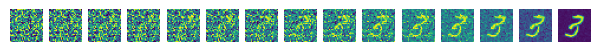

Epoch 2 | Step 200 | Loss: 0.037388429045677185 | C: 4


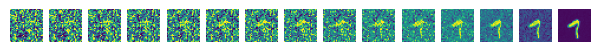

Epoch 2 | Step 300 | Loss: 0.04795060679316521 | C: 5


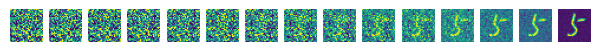

Epoch 2 | Step 400 | Loss: 0.03683870658278465 | C: 6


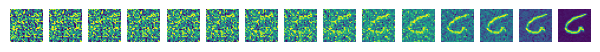

Epoch 2 | Step 500 | Loss: 0.0369572788476944 | C: 7


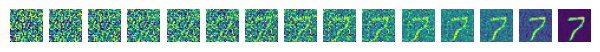

Epoch 3 | Step 000 | Loss: 0.03874615207314491 | C: 8


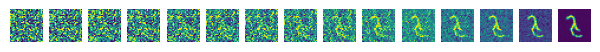

Epoch 3 | Step 100 | Loss: 0.04058677330613136 | C: 9


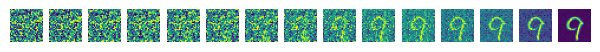

Epoch 3 | Step 200 | Loss: 0.038434430956840515 | C: 0


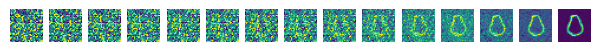

Epoch 3 | Step 300 | Loss: 0.031973011791706085 | C: 1


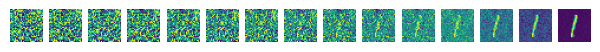

Epoch 3 | Step 400 | Loss: 0.03443150222301483 | C: 2


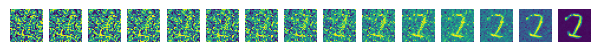

Epoch 3 | Step 500 | Loss: 0.03697723522782326 | C: 3


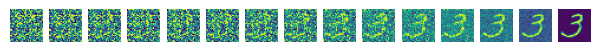

Epoch 4 | Step 000 | Loss: 0.03486311435699463 | C: 4


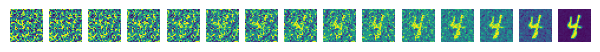

Epoch 4 | Step 100 | Loss: 0.03594037517905235 | C: 5


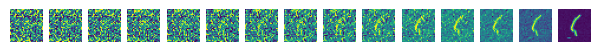

Epoch 4 | Step 200 | Loss: 0.04012104123830795 | C: 6


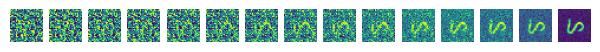

Epoch 4 | Step 300 | Loss: 0.038257140666246414 | C: 7


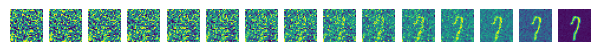

Epoch 4 | Step 400 | Loss: 0.03612319007515907 | C: 8


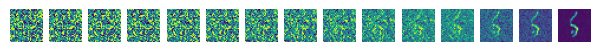

Epoch 4 | Step 500 | Loss: 0.034197576344013214 | C: 9


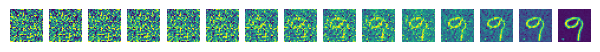

In [37]:
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 5
preview_c = 0

model.train()
for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
        c_drop_prob = 0.1
        optimizer.zero_grad()

        t = torch.randint(0, T, (BATCH_SIZE,), device=device).float()
        x = batch[0].to(device)
        c_hot, c_mask = get_context_mask(batch[1], c_drop_prob)  # New
        loss = get_loss(model, x, t, c_hot, c_mask)
        loss.backward()
        optimizer.step()

        if epoch % 1 == 0 and step % 100 == 0:
            print(f"Epoch {epoch} | Step {step:03d} | Loss: {loss.item()} | C: {preview_c}")
            c_drop_prob = 0 # Do not drop context for preview
            c_hot, c_mask = get_context_mask(torch.Tensor([preview_c]), c_drop_prob)
            sample_images(model, IMG_CH, IMG_SIZE, ncols, c_hot, c_mask)
            preview_c = (preview_c + 1) % N_CLASSES

## 6.5 采样
｜Sampling

这是拼图的最后一块。我们可以将生成器与分类器进行比较，但就目前而言，它获得 95% 以上准确率的可能性微乎其微。让我们使用 `无分类器扩散引导` 来提高我们的胜算。

**TODO**: 下面的 `sample_w` 公式中有一个 `FIXME`。你能记住将权重添加到扩散过程的公式吗？

In [49]:
# @torch.no_grad()
# def sample_w(model, c, w):
#     input_size = (IMG_CH, IMG_SIZE, IMG_SIZE)
#     n_samples = len(c)
#     w = torch.tensor([w]).float()
#     w = w[:, None, None, None].to(device)  # Make w broadcastable
#     x_t = torch.randn(n_samples, *input_size).to(device)

#     # One c for each w
#     c = c.repeat(len(w), 1)

#     # Double the batch
#     c = c.repeat(2, 1)

#     # Don't drop context at test time
#     c_mask = torch.ones_like(c).to(device)
#     c_mask[n_samples:] = 0.0

#     x_t_store = []
#     for i in range(0, T)[::-1]:
#         # Duplicate t for each sample
#         t = torch.tensor([i]).to(device)
#         t = t.repeat(n_samples, 1, 1, 1)

#         # Double the batch
#         x_t = x_t.repeat(2, 1, 1, 1)
#         t = t.repeat(2, 1, 1, 1)

#         # Find weighted noise
#         e_t = model(x_t, t, c, c_mask)
#         e_t_keep_c = e_t[:n_samples]
#         e_t_drop_c = e_t[n_samples:]
#         e_t = FIXME

#         # Deduplicate batch for reverse diffusion
#         x_t = x_t[:n_samples]
#         t = t[:n_samples]
#         x_t = reverse_q(x_t, t, e_t)

#     return x_t

In [50]:
@torch.no_grad()
def sample_w(model, c, w):
    input_size = (IMG_CH, IMG_SIZE, IMG_SIZE)
    n_samples = len(c)
    w = torch.tensor([w]).float()
    w = w[:, None, None, None].to(device)  # Make w broadcastable
    x_t = torch.randn(n_samples, *input_size).to(device)

    # One c for each w
    c = c.repeat(len(w), 1)

    # Double the batch
    c = c.repeat(2, 1)

    # Don't drop context at test time
    c_mask = torch.ones_like(c).to(device)
    c_mask[n_samples:] = 0.0

    x_t_store = []
    for i in range(0, T)[::-1]:
        # Duplicate t for each sample
        t = torch.tensor([i]).to(device)
        t = t.repeat(n_samples, 1, 1, 1)

        # Double the batch
        x_t = x_t.repeat(2, 1, 1, 1)
        t = t.repeat(2, 1, 1, 1)

        # Find weighted noise
        e_t = model(x_t, t, c, c_mask)
        e_t_keep_c = e_t[:n_samples]
        e_t_drop_c = e_t[n_samples:]
        e_t = (1 + w) * e_t_keep_c - w * e_t_drop_c

        # Deduplicate batch for reverse diffusion
        x_t = x_t[:n_samples]
        t = t[:n_samples]
        x_t = reverse_q(x_t, t, e_t)

    return x_t

**TODO**:  让我们测试一下。试着运行下面的单元格几次。你能通过改变 `w` 使数字始终可识别吗？


In [54]:
# model.eval()
# w = 0.0  # Change me
# c = torch.arange(N_CLASSES).to(device)
# c_drop_prob = 0 
# c_hot, c_mask = get_context_mask(c, c_drop_prob)

# x_0 = sample_w(model, c_hot, 1.0)
# other_utils.to_image(make_grid(x_0.cpu(), nrow=N_CLASSES))

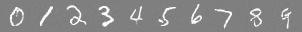

In [55]:
model.eval()
w = 2.0  # Change me
c = torch.arange(N_CLASSES).to(device)
c_drop_prob = 0 
c_hot, c_mask = get_context_mask(c, c_drop_prob)

x_0 = sample_w(model, c_hot, 1.0)
other_utils.to_image(make_grid(x_0.cpu(), nrow=N_CLASSES))

这对于自动评分器很重要。输出形状是否为 `[10, 1, 28, 28]`？如果是，你就可以测试模型了！


In [56]:
x_0.shape

torch.Size([10, 1, 28, 28])

## 6.6 运行评估
｜Run the Assessment

要评估你的模型，请运行以下两个单元格。

**注意:** `run_assessment` 假设你的模型名为 `model` 并且你的扩散权重名为 `w`。如果由于任何原因你修改了这些变量名称，请更新传递给 `run_assessment` 的参数名称。如果你的结果很接近，但还没有达到，请尝试更改上面的 `w`。


In [57]:
from run_assessment import run_assessment

In [58]:
run_assessment(model, sample_w, w)

Evaluating model...

Classifier prediction for generated `0`: [0, 0, 0, 0, 0] - 100.0% Accuracy
Classifier prediction for generated `1`: [1, 1, 1, 1, 1] - 100.0% Accuracy
Classifier prediction for generated `2`: [2, 2, 2, 2, 2] - 100.0% Accuracy
Classifier prediction for generated `3`: [3, 3, 3, 3, 3] - 100.0% Accuracy
Classifier prediction for generated `4`: [4, 4, 4, 4, 4] - 100.0% Accuracy
Classifier prediction for generated `5`: [5, 5, 5, 5, 5] - 100.0% Accuracy
Classifier prediction for generated `6`: [6, 6, 6, 6, 6] - 100.0% Accuracy
Classifier prediction for generated `7`: [7, 7, 7, 7, 7] - 100.0% Accuracy
Classifier prediction for generated `8`: [8, 8, 8, 8, 8] - 100.0% Accuracy
Classifier prediction for generated `9`: [9, 9, 9, 9, 9] - 100.0% Accuracy
Final Accuracy - 100.0%

Accuracy required to pass the assessment is 95% or greater.
Congratulations! You passed the assessment!
See instructions below to generate a certificate.


## 6.7 生成证书
｜Generate a Certificate

如果你通过了评估，请返回课程页面（显示在下面）并点击“评估任务”按钮，这将为你生成该课程的证书。


<img src="./images/certificate.png" style="width: 800px;">

<center><a href="https://5loi.com/about_loi"> <img src="images/DLI_Header.png" alt="Header" style="width: 400px;"/> </a></center>